# Optimzing Fuelling

In [1]:
import numpy as np
from copy import deepcopy

from cpp_algorithms.constants import FU, OB 
from cpp_algorithms.common_helpers import is_valid
from cpp_algorithms.dist_fill import dist_fill 

The functions are all from the `fuel_path` module, just copied into this notebook.

**Constants**
- `FU` – Value in the dist_map that pertains to the fuelling point, don't change, it's 0.
- `OB` – Value in that pertains to an obstacle, don't change, it's -1.

**Helpers**
- `dist_fill` – Flood fills an area map with L1 distances from the start point.
- `is_valid` – Checks if a coord is within bounds and not an obstacle on the given area_map.

## Fuel Path Functions

Functions from `fuel_path_helpers.py`

In [2]:
def udlr(x,y):
    """
    Returns : Up Down Left Right, from (x,y)
    """
    return [(x,y+1),(x,y-1),(x-1,y),(x+1,y)]

def get_step(dist_map, point, obs=OB):
    """
    Get smallest valid L1 step from `point`.
    """
    sh = dist_map.shape
    min_ = float('inf')
    p = point
    for direc in udlr(*point):
        x,y = direc
        if x < 0 or y < 0 or \
            x >= sh[0] or y >= sh[1]:
            continue
        val = dist_map[direc]
        if val < min_ and val != obs:
            min_ = val
            p = direc
    return p, min_

def path_to_fuel(dist_map, loc, fuel=FU, obs=OB):
    """
    PARAMETERS
    ---
    dist_map : copy of the area_map 
    loc : (x,y) robot location
    fuel : value of fuel on the `dist_map`
    obs : value of obstacle on the `dist_map`
    """
    loc = tuple(loc)
    path = [loc]
    cell = dist_map[loc]
    while cell != fuel:
        loc, cell = get_step(dist_map, loc, obs)
        path.append(loc)
    return path

def get_refuel_idx(dist_map, coverage_path, fuel_cap):
    """
    PARAMETERS
    ---
    dist_map : distance map where fuel points are 0 valued, 
        (m,n) shape nd array
    coverage_path : sequence of coords that traverses the `dist_map`.
        list of tuples, [(x1,y1),...,(xm,ym)]
    fuel_cap : capacity of the fuel required by the drone, int.
    
    RETURNS
    ---
    points : indices in the coverage_path where refuelling detour is taken.
    fcap : fuel capacity at every point in the coverage_path.
    """
    coverage_path = np.array(coverage_path)
    x,y = coverage_path.T
    dist = dist_map.copy()[x,y]
    plen = dist.shape[0]
    fcap = np.full(dist.shape, 0)

    points = []

    cu = 0 # coverage_path distance travelled by the drone
    fuel_req = 0 # initial req 0 cause starting with full tank

    i = 0
    while True:
        i+=1
        ini_fuel = (fuel_cap - fuel_req)
        assert ini_fuel > 0, "no fuel left to complete coverage_path" 
        # start : how many points have previously been covered.
        # end   : how many points can be covered with available fuel.
        start = cu
        end = cu + ini_fuel
        
        # If end index overshoots coverage_path length,
        # end index should be the coverage_path length (ie last position -1)
        if plen - end < 0:
            end = plen
        sl = slice(start, end)

        # Amount of distance that can be travelled by the drone
        # taking into account the last loc.
        p_seg_len = end - start
        fin_fuel = ini_fuel - p_seg_len

        # Possible fuel remaining starting index 
        fcap[sl] = np.arange(ini_fuel, fin_fuel, -1)
        # if : Remaining fuel is sufficient.
        if ini_fuel - (plen - cu) >=0:
            break

        freq = fcap[sl] - dist[sl]
        try:
            idx = freq[freq >= 0].argmin()
        except ValueError:
            raise ValueError("coverage path can't be traversed, insufficient fuel capacity")
        
        if len(points) > 1 and points[-1] == points[-2]:
            raise ValueError(f"coverage path can't be traversed, insufficient fuel capacity\n stuck at coverage path index :{points[-1]}")

        cu += idx

        points.append(cu)
        fuel_req = dist[cu]
    return points, fcap

Functions from `fuel_path.py`

In [3]:
def get_fuel_paths(coverage_path, area_map, fuel_points, fuel_capacity):
    """
    Calculates detour paths to the closest fuel point with optimal
    fuel consumption.

    PARAMETERS
    ---
    coverage_path : the drone coverage path as a list of tuples
        [(x1,y1),...,(xm,ym)]

    area_map : 2 dim numpy array of the area, 
        obstacles : -1, area to map: 0

    fuel_points : non obstacle points on the map which are
        fuel_points as a list of tuples.
        [(x1,y1),...,(xm,ym)]

    fuel_capacity : int, fuel capacity of the drone interms of 
        1 = time required to move to an adjacent cell.


    RETURNS
    ---
    fuel_dist_map : a matrix of distance to the closest fuel point.

    detour_indices : indices of the path list where detour for 
        fuelling has to be taken.

    paths_to_refuel : list of shortest path starting at `path[detour_inces[i]]` 
        and ending at `fuel_points[i]`.

    fuel_capacity : list of how much fuel is remaining, same lenght as path.
    """
    fuel_dist_map = dist_fill(area_map, fuel_points)
    detour_indices, fuel_capacity = get_refuel_idx(fuel_dist_map, coverage_path, fuel_capacity)

    paths_to_refuel = []
    for idx in detour_indices:
        detour_location = coverage_path[idx]
        path_to_refuel = path_to_fuel(fuel_dist_map, detour_location)
        paths_to_refuel.append(path_to_refuel)
    
    return (
        fuel_dist_map,
        detour_indices,
        paths_to_refuel,
        fuel_capacity
    )

def splice_paths(coverage_path, fuel_paths, detour_idx, double_center=False):
    """
    Inserts detour path to the fuelling station into the original path
    and returns it along with start and end indices of the full path which.

    PARAMETERS
    ---
    coverage_path : the drone coverage path as a list of tuples
        [(x1,y1),...,(xm,ym)]

    fuel_paths : list of fuel paths
        [[(x1,y1),...,(xn,yn)],...,[...]]

    detour_idx : indices where the drone takes a detour from the main path.

    double_center : whether the fuel point coordinate should be repeated.


    RETURNS
    ---
    full_path : The entire path of the drone on the map.

    detour_start_end_idx : Indices of the full path where
        detour starts and ends, they are the same coords.
        (start, end) 
    """
    coverage_path = deepcopy(coverage_path)
    fuel_paths = deepcopy(fuel_paths)
    detour_start_end_idx = []
    segments = []
    last_idx = 0
    cumu_len = 0
    for idx,fuel_path in zip(detour_idx,fuel_paths):
        s_e = []
        
        seg = np.array(coverage_path[last_idx:idx])
        segments.append(seg)
        cumu_len += seg.shape[0]
        s_e.append(cumu_len)
        
        if double_center:
            splice_in = [*fuel_path,*fuel_path[::-1][:-1]]
        else:
            splice_in = [*fuel_path,*fuel_path[::-1][1:-1]]
        
        seg = np.array(splice_in)
        cumu_len += seg.shape[0]
        s_e.append(cumu_len)
        
        detour_start_end_idx.append(tuple(s_e))
        segments.append(seg)
        last_idx = idx
    
    segments.append(coverage_path[last_idx:])
    full_path = np.concatenate(segments)
    
    return full_path, detour_start_end_idx

## Usage

In [4]:
from cpp_algorithms import bcd
from cpp_algorithms import get_all_area_maps, get_random_coords
from cpp_algorithms.testers import imshow, imshow_scatter
from cpp_algorithms.testers.display_funcs import printer
from cpp_algorithms.testers.metrics import coverage_metrics, fuel_metrics

### Getting the coverage path using bcd

     points_to_visit : 1318
     obstacle_points : 1182
      points_visited : 1318
   coverage_path_len : 1754
            coverage : 1.0
          redundancy : 0.33080424886191206
          area_shape : (50, 50)


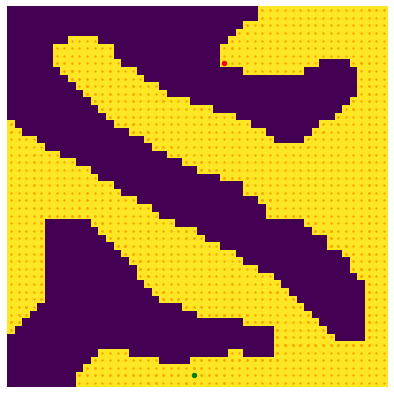

In [6]:
# ---- Get The Map ----
area_maps = get_all_area_maps("./test_maps/")   # all area maps in the folder
area_map = area_maps[10]

# ---- Calculate Coverage Path ----
start_point = get_random_coords(area_map, 1)[0] # returns a random coord not on an obstacle
coverage_path = bcd(area_map, start_point)      # calculate coverage path using bcd
end_point = coverage_path[-1]

# ---- Display The Stuff ----
imshow(area_map, figsize=(7,7));                # shows the area_map
imshow_scatter(coverage_path, s=2)              # show the coverage_path (orange_points)
imshow_scatter([start_point], color="green")    # show the start_point   (green)
imshow_scatter([end_point], color="red")        # show the end_point     (red)

cm = coverage_metrics(area_map, coverage_path)  # calculate coverage metrics
printer(cm)                                     # print coverage metrics

### Calculating the fuel path 

In [7]:
fuel_points = get_random_coords(area_map, 2) # 2 random coords for fuel points
fuel_capacity = 300

# Compute the fuel paths, returns 4 values. 
# Check the docstring (Shift-Tab in the function signature).
dist_map, detour_indices, fuel_paths, fuel_capacity = \ # (code folding)
get_fuel_paths(coverage_path, area_map, fuel_points, fuel_capacity,)

#### Displaying the return values

fp   [(35, 48), (35, 47), (35, 46), (34, 46)]
idx  [261, 488, 698, 905, 1155, 1426, 1700]
fc   [300 299 298 297 296 295 294 293 292 291]


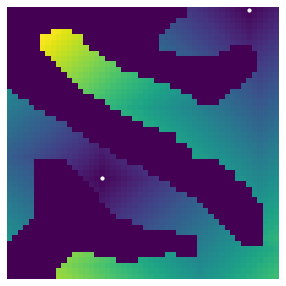

In [8]:
print("fp  ", fuel_paths[0][:4])  # All the fuel paths
print("idx ", detour_indices)     # Indices in the cov path where detours to the fuel point
print("fc  ", fuel_capacity[:10]) # Remaining fuel capacity at every point in the cov path

imshow(dist_map);                 # Map of distances to the fuel points
imshow_scatter(fuel_points, color="white", s=10)

#### Displaying the paths

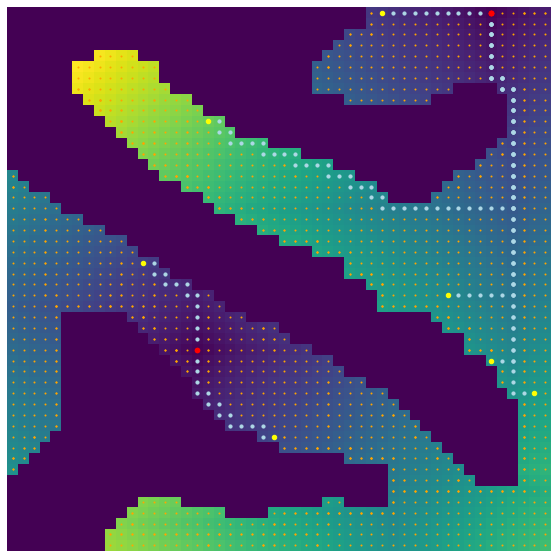

In [9]:
imshow(dist_map,(10,10))
imshow_scatter(coverage_path, s=1) # The coverage path
[imshow_scatter(fuel_path, color="lightblue",s=10) for fuel_path in fuel_paths]; # The entire fuel path
[imshow_scatter([fuel_path[ 0]], color="yellow") for fuel_path in fuel_paths];   # The fuel start points
[imshow_scatter([fuel_path[-1]], color="red") for fuel_path in fuel_paths];      # The fuel end points